In [1]:
import torch
import torchvision
import torchvision.transforms as transforms 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print (len(trainset))
print (len(trainloader))

50000
12500


In [5]:
trainset[1]

(tensor([[[ 0.2078, -0.0118, -0.1765,  ..., -0.2863, -0.3176, -0.3804],
          [ 0.0980,  0.1373, -0.0196,  ..., -0.2471, -0.3961, -0.4431],
          [ 0.0980,  0.0902, -0.0980,  ..., -0.3804, -0.4667, -0.4745],
          ...,
          [ 0.3725,  0.2235,  0.2078,  ..., -0.6706, -0.5216, -0.2706],
          [ 0.2941,  0.2235,  0.2471,  ..., -0.1922, -0.0353,  0.0275],
          [ 0.2784,  0.2392,  0.2784,  ...,  0.1216,  0.1216,  0.1216]],
 
         [[ 0.3882,  0.0745, -0.1843,  ..., -0.2549, -0.2941, -0.3647],
          [ 0.2549,  0.2000, -0.0196,  ..., -0.2235, -0.3725, -0.4275],
          [ 0.2157,  0.1451, -0.0980,  ..., -0.3569, -0.4510, -0.4588],
          ...,
          [ 0.3098,  0.2078,  0.2549,  ..., -0.7333, -0.5843, -0.3490],
          [ 0.2078,  0.1922,  0.2627,  ..., -0.2706, -0.1059, -0.0510],
          [ 0.1608,  0.1608,  0.2235,  ...,  0.0431,  0.0510,  0.0431]],
 
         [[ 0.4667,  0.0667, -0.2549,  ..., -0.4431, -0.4431, -0.4510],
          [ 0.3255,  0.2078,

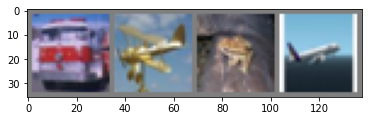

truck plane  frog plane


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class ResNet(nn.Module):
    
    def __init__(self, n=7, res_option='A', use_dropout=False):
        super(ResNet, self).__init__()
        self.res_option = res_option
        self.use_dropout = use_dropout
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        self.layers1 = self._make_layer(n, 16, 16, 1)
        self.layers2 = self._make_layer(n, 32, 16, 2)
        self.layers3 = self._make_layer(n, 64, 32, 2)
        self.avgpool = nn.AvgPool2d(8)
        self.linear = nn.Linear(64, 10)
    
    def _make_layer(self, layer_count, channels, channels_in, stride):
        return nn.Sequential(
            ResBlock(channels, channels_in, stride, res_option=self.res_option, use_dropout=self.use_dropout),
            *[ResBlock(channels) for _ in range(layer_count-1)])
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu1(out)
        out = self.layers1(out)
        out = self.layers2(out)
        out = self.layers3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

class ResBlock(nn.Module):
    
    def __init__(self, num_filters, channels_in=None, stride=1, res_option='A', use_dropout=False):
        super(ResBlock, self).__init__()
        
        # uses 1x1 convolutions for downsampling
        if not channels_in or channels_in == num_filters:
            channels_in = num_filters
            self.projection = None
        else:
            if res_option == 'A':
                self.projection = IdentityPadding(num_filters, channels_in, stride)
            elif res_option == 'B':
                self.projection = ConvProjection(num_filters, channels_in, stride)
            elif res_option == 'C':
                self.projection = AvgPoolPadding(num_filters, channels_in, stride)
        self.use_dropout = use_dropout

        self.conv1 = nn.Conv2d(channels_in, num_filters, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters)
        if self.use_dropout:
            self.dropout = nn.Dropout(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_dropout:
            out = self.dropout(out)
        if self.projection:
            residual = self.projection(x)
        out += residual
        out = self.relu2(out)
        return out


# various projection options to change number of filters in residual connection
# option A from paper
class IdentityPadding(nn.Module):
    def __init__(self, num_filters, channels_in, stride):
        super(IdentityPadding, self).__init__()
        # with kernel_size=1, max pooling is equivalent to identity mapping with stride
        self.identity = nn.MaxPool2d(1, stride=stride)
        self.num_zeros = num_filters - channels_in
    
    def forward(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.num_zeros))
        out = self.identity(out)
        return out

# option B from paper
class ConvProjection(nn.Module):

    def __init__(self, num_filters, channels_in, stride):
        super(ResA, self).__init__()
        self.conv = nn.Conv2d(channels_in, num_filters, kernel_size=1, stride=stride)
    
    def forward(self, x):
        out = self.conv(x)
        return out

# experimental option C
class AvgPoolPadding(nn.Module):

    def __init__(self, num_filters, channels_in, stride):
        super(AvgPoolPadding, self).__init__()
        self.identity = nn.AvgPool2d(stride, stride=stride)
        self.num_zeros = num_filters - channels_in
    
    def forward(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.num_zeros))
        out = self.identity(out)
        return out
net = ResNet()

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
net.to(device)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (layers1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNor

In [10]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)#.to(device)
        # print('inputs.shape',inputs.shape)
        # print('outputs.shape',outputs.shape)
        # print('labels.shape',labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.080
[1,  4000] loss: 1.737
[1,  6000] loss: 1.533
[1,  8000] loss: 1.388
[1, 10000] loss: 1.285
[1, 12000] loss: 1.196
[2,  2000] loss: 1.054
[2,  4000] loss: 1.025
[2,  6000] loss: 0.978
[2,  8000] loss: 0.939
[2, 10000] loss: 0.900
[2, 12000] loss: 0.881
[3,  2000] loss: 0.787
[3,  4000] loss: 0.786
[3,  6000] loss: 0.754
[3,  8000] loss: 0.778
[3, 10000] loss: 0.723
[3, 12000] loss: 0.715
[4,  2000] loss: 0.660
[4,  4000] loss: 0.630
[4,  6000] loss: 0.648
[4,  8000] loss: 0.632
[4, 10000] loss: 0.616
[4, 12000] loss: 0.644
[5,  2000] loss: 0.555
[5,  4000] loss: 0.569
[5,  6000] loss: 0.550
[5,  8000] loss: 0.532
[5, 10000] loss: 0.566
[5, 12000] loss: 0.546
Finished Training


In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

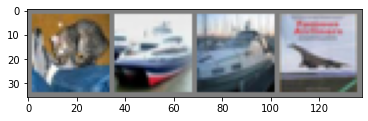

GroundTruth:    cat  ship  ship plane


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
net = ResNet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
outputs = net(images)

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # images, labels = images.cuda(), labels.cuda()
        outputs = net(images)#.cuda()
        # outputs.cuda()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 77 %


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # images, labels = images.cuda(), labels.cuda()
        # outputs.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        # print('label', labels,'     ', 'predicted', predicted)
        # print('outputs',outputs)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 92 %
Accuracy of  bird : 72 %
Accuracy of   cat : 63 %
Accuracy of  deer : 69 %
Accuracy of   dog : 56 %
Accuracy of  frog : 81 %
Accuracy of horse : 70 %
Accuracy of  ship : 89 %
Accuracy of truck : 90 %


**Additional Filter Design**

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv3 = nn.Conv2d(16, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = F.relu(self.conv3(x))
        # x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# net = Net()

In [22]:
from torch.utils.data import Subset
import random
def Additional_Cat_Filter(name):
    dog_idx, cat_idx = 5, 3
    dog_indices = []
    cat_indices = []

    for i in range(len(trainset)):
        current_class = trainset[i][1]
        if current_class == dog_idx:
            dog_indices.append(i)
        elif current_class == cat_idx:
            cat_indices.append(i)
    dog_ = dog_indices
    cat_ = cat_indices
    a = dog_+cat_
    random.shuffle(a)
    dog_vs_cat_train_dataset = Subset(trainset, a)#+other_indices)

    dog_idx, cat_idx = 5, 3
    dog_indices = []
    cat_indices = []

    for i in range(len(testset)):
        current_class = testset[i][1]
        if current_class == dog_idx:
            dog_indices.append(i)
        elif current_class == cat_idx:
            cat_indices.append(i)
    ces = dog_indices
    cat_ind = cat_indices
    a = ces+cat_ind
    random.shuffle(a)
#     print('a',a)
    dog_vs_cat_test_dataset = Subset(testset, a)#+other_indices)
#     print('dog_vs_cat_test_dataset',dog_vs_cat_test_dataset)
    return dog_vs_cat_train_dataset, dog_vs_cat_test_dataset
dog_vs_cat_train_dataset, dog_vs_cat_test_dataset = Additional_Cat_Filter('dog')

In [24]:
PATH = './cifar_net_cat_vs_dog.pth'
net_cat_dog = Net()
net_cat_dog.load_state_dict(torch.load(PATH))
outputs = net_cat_dog(images[None,...])

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in dog_vs_cat_test_dataset:
        # print(data)
        images, labels = data
        # print(images)
        # images, labels = images.cuda(), labels.cuda()
        outputs = net_cat_dog(images[None,...])#.cuda()
        # outputs.cuda()
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 92 %


In [31]:
PATH = './cifar_net.pth'
ResNet_cat_dog = ResNet()
ResNet_cat_dog.load_state_dict(torch.load(PATH))
outputs = ResNet_cat_dog(images)

# Test Start

In [ ]:
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in dog_vs_cat_test_dataset:
#         # print(data)
#         images, labels = data
#         # print(images)
#         # images, labels = images.cuda(), labels.cuda()
#         outputs = net_cat_dog(images[None,...])#.cuda()
#         # outputs.cuda()
#         _, predicted = torch.max(outputs.data, 1)
#         total += 1
#         correct += (predicted == labels).sum().item()

# print('Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct / total))

In [56]:
correct = 0
total = 0
counter1 = 0
with torch.no_grad():
    for data in testloader:
        if counter1:
            images, labels = data
            # images, labels = images.cuda(), labels.cuda()
            outputs = ResNet_cat_dog(images)#.cuda()
            # outputs.cuda()
            index = []
            count = True
            for n in range(4):
                for i in outputs.data[n]:
                    if i !=outputs.data[n][3]:
                        if i != outputs.data[n][5]:
                            if i >outputs.data[n][3]:
                                if i>outputs.data[n][5]:
                                    count = False
                            
                            
                if count:
#                     print(outputs.data[n][5])
#                     print(outputs.data[n][3])
                    print('outputs.data',outputs.data[n])
                    _, predicted = torch.max(outputs.data, 1)

#                     total += labels.size(0)
                    total+=1
                    correct += (predicted[n] == labels[n]).sum().item()
        counter1 +=1
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

outputs.data tensor([-2.2602, -4.5539,  1.4402,  4.2423,  2.0743,  1.4814,  3.1878, -0.1157,
        -1.8329, -5.3508])
outputs.data tensor([-1.7427, -0.8890,  2.1039,  3.0648, -2.3965,  6.0167, -2.6144, -0.3186,
        -3.9546,  0.3320])
outputs.data tensor([-2.6463, -1.8634,  2.6666,  3.7911, -2.8919,  2.6375,  0.4945,  0.0916,
        -3.0194, -0.8411])
outputs.data tensor([-0.2047, -1.8724,  0.4424,  2.7445,  0.2420,  1.9438,  0.1942, -1.6041,
        -3.2119,  0.3442])
outputs.data tensor([-1.8320, -3.3814, -1.4244,  5.1562, -2.3651,  2.9306,  3.6598, -3.5726,
        -1.7707,  0.6812])
outputs.data tensor([ 1.3625, -4.1608,  2.7395,  3.9973,  0.2369,  1.9307, -1.9636,  3.1659,
        -5.3289, -2.4253])
outputs.data tensor([-1.1764, -3.7865,  2.4451,  3.2827,  1.8843,  4.4864, -1.2485,  0.8796,
        -4.5162, -2.8108])
outputs.data tensor([ 3.2324, -2.3520,  2.7173,  4.0294, -0.8149,  4.7040, -1.5146, -1.8887,
        -4.5991, -2.5325])
outputs.data tensor([-0.6904, -2.3244,  

outputs.data tensor([-1.2572, -4.9426,  1.8239,  2.7100,  2.3560,  0.4691,  1.9491,  0.0374,
        -2.0438, -2.4407])
outputs.data tensor([-2.3284, -2.4773, -0.7134,  4.7273, -0.7185,  2.0952, -0.5439, -0.2849,
        -1.9698,  0.5504])
outputs.data tensor([-3.0963, -4.9442,  2.6075,  4.6272,  2.0956,  7.0434, -0.4138,  1.7006,
        -5.5853, -3.8260])
outputs.data tensor([-0.7587,  1.3330,  0.8454,  2.2728, -3.6479,  0.8626,  1.7401, -4.4217,
         2.1977, -2.4645])
outputs.data tensor([ 0.0075,  1.5132,  1.1264,  1.5599, -1.2329,  1.6136, -0.1217, -3.1267,
        -0.2453, -1.7021])
outputs.data tensor([-1.1708, -1.8034,  2.0554,  2.7341, -2.1483,  3.2742,  0.4104,  0.5908,
        -5.0334,  0.1295])
outputs.data tensor([-1.3952, -4.4642,  5.7927,  2.3477, -0.2003,  5.9153,  1.2103, -0.6050,
        -4.9668, -3.8192])
outputs.data tensor([ 0.4178, -1.6853, -1.8038,  4.8542,  1.2554,  3.3884, -3.0980,  2.2082,
        -5.4782, -0.4252])
outputs.data tensor([-0.1267, -0.6008, -

outputs.data tensor([-3.4511, -2.3987,  0.0969,  1.7271,  0.0614,  1.7150, -1.7603,  1.1398,
        -0.3441,  1.2517])
outputs.data tensor([-1.5179, -2.7987,  1.4566,  1.6872,  2.0751,  3.1887, -3.1637,  2.5676,
        -3.3442, -0.6957])
outputs.data tensor([-1.2989, -0.3101, -1.0241,  3.1772, -2.2327,  7.4615, -5.8240,  1.0211,
        -4.1002,  3.0831])
outputs.data tensor([ 2.0732, -1.8544,  0.6138,  4.1658,  0.9768,  1.3725, -1.5528, -3.0640,
        -1.7395, -1.8229])
outputs.data tensor([-0.6423, -4.3562,  1.6206,  5.1235,  0.4859,  1.7878, -0.0636, -0.5244,
        -0.8579, -4.4187])
outputs.data tensor([-0.8791, -2.0075,  2.2786,  1.8693,  0.8979,  3.7224, -0.3899, -0.9226,
        -1.6026, -3.3875])
outputs.data tensor([-3.2264, -0.2718, -0.1759,  4.3082,  2.0800,  2.6087,  0.7687, -1.4023,
        -5.7585, -0.5575])
outputs.data tensor([ 0.3526, -2.5876,  1.0663,  2.9478,  0.7818,  2.3108, -1.6406, -3.8477,
         2.0524, -2.1524])
outputs.data tensor([ 0.2412, -0.4271,  

outputs.data tensor([ 1.5912, -1.8759,  1.1822,  2.6146,  1.3371,  1.7393, -0.6397, -1.2859,
        -3.1804, -2.2479])
outputs.data tensor([-1.2331, -3.1367,  1.1974,  5.5071, -2.0813,  1.9003,  2.7688, -1.7675,
        -3.0138, -2.5079])
outputs.data tensor([-3.0581, -1.9841,  1.6524,  3.0637, -0.2665,  4.5055, -1.1037,  2.6767,
        -3.5655, -1.9153])
outputs.data tensor([-3.0021, -2.6309, -1.8071,  6.1151, -1.2047,  2.9026,  0.4007,  0.0314,
        -2.5862, -0.0544])
outputs.data tensor([-2.9055, -2.9551,  1.9087,  2.5763,  2.1191,  1.5213, -0.1685,  1.8066,
        -3.4988, -1.3207])
outputs.data tensor([ 1.6123, -2.8734,  1.3640,  3.1445, -0.1510,  0.5728, -4.2716,  0.0231,
        -0.3867,  0.2596])
outputs.data tensor([-0.7796, -1.7777,  0.0275,  3.9689,  0.0397,  2.8701, -0.7065, -1.2940,
        -2.3197, -0.6257])
outputs.data tensor([-0.3913, -3.9504,  0.2658,  4.3816,  0.2155,  1.3409,  0.7204, -0.3889,
        -1.7552, -2.2255])
outputs.data tensor([ 0.2409, -0.7304,  

outputs.data tensor([-5.3793, -0.6905, -0.4493,  2.5207, -1.2641,  5.1665,  0.4200,  0.2474,
        -3.0443,  0.9742])
outputs.data tensor([-3.4751, -4.3263,  4.2785,  4.5221,  3.0758,  4.0830,  0.7538, -1.4211,
        -4.9261, -3.7811])
outputs.data tensor([-2.4185, -1.4886,  3.1423,  2.4847,  0.7013,  6.1443, -1.4449,  0.5525,
        -4.6965, -3.2067])
outputs.data tensor([-3.1550, -3.6096,  1.3895,  4.1077, -0.7505,  4.4192,  0.1870, -2.0926,
        -2.3804,  0.3621])
outputs.data tensor([ 0.3701, -1.7562,  3.5942,  4.6829, -4.6014,  8.1496, -3.2261,  1.6934,
        -3.0843, -4.8052])
outputs.data tensor([-1.9510, -5.3208,  1.9865,  4.3684, -1.0667,  2.0940,  1.0399,  2.8359,
        -1.1710, -4.0129])
outputs.data tensor([-2.3410, -2.0711,  3.6706,  4.3256, -0.2895,  4.4198, -0.2760, -1.8273,
        -4.2306, -1.8535])
outputs.data tensor([-4.1253, -4.0799,  1.9909,  4.1356,  3.3450,  4.3045,  1.4989,  0.7373,
        -4.6314, -4.8362])
outputs.data tensor([ 1.7868, -6.0832, -

outputs.data tensor([ 0.6998, -4.4500,  2.1305,  3.0557,  0.0058,  0.9081,  1.9045,  0.5333,
        -2.5128, -3.5001])
outputs.data tensor([-0.0815, -3.2694,  1.1003,  6.5191,  1.0930,  2.8609,  1.6128, -2.3474,
        -4.7880, -3.9028])
outputs.data tensor([-4.5648, -2.5065,  2.6457,  3.6956,  2.8674,  3.0562,  3.5067, -0.6471,
        -5.5820, -3.8161])
outputs.data tensor([-1.7592, -2.8809, -0.1889,  6.4440, -0.7610,  4.5625, -1.9310, -1.3510,
        -1.7852, -1.1929])
outputs.data tensor([-1.8809, -7.4406,  3.9081,  2.8399,  3.7521,  4.4116,  2.2952,  1.2488,
        -3.7824, -5.6072])
outputs.data tensor([ 0.2846, -1.8986,  2.8127,  2.8969, -2.6875,  0.7409,  1.9400, -4.8592,
        -0.2263, -1.2944])
outputs.data tensor([-3.6206, -2.1434,  3.4140,  2.1578, -0.4395,  4.8615,  0.3662,  1.5087,
        -5.7315, -1.3259])
outputs.data tensor([ 0.3190, -2.7435,  3.2120,  4.8042, -3.2851,  8.4630, -3.1833,  0.3198,
        -3.4235, -3.5583])
outputs.data tensor([-3.3137, -2.0066,  

outputs.data tensor([-1.3330, -0.2477,  2.3669,  2.3227, -2.4588,  3.7016,  0.3203, -1.3792,
        -1.0730, -3.3193])
outputs.data tensor([-0.9611, -3.2220,  1.0893,  2.4156,  0.3707,  1.3349, -0.5865, -0.0574,
        -3.2536,  1.2742])
outputs.data tensor([-0.8142, -1.5917,  1.2821,  2.3455,  1.8259,  2.2569, -0.8275,  1.1814,
        -3.7163, -2.7486])
outputs.data tensor([-0.5842, -2.8398, -1.5338,  4.4524,  0.4977,  0.0076,  0.0990, -1.0549,
        -1.5057,  1.1913])
outputs.data tensor([-3.0552, -1.9759,  3.3894,  2.0734,  1.2580,  4.3612,  1.1097, -0.9067,
        -5.0221, -2.4677])
outputs.data tensor([-1.4619, -3.5118,  2.8791,  4.7699, -3.7743,  3.0484,  0.2590,  2.8793,
        -3.6264, -2.1804])
outputs.data tensor([ 2.2947, -2.9060,  0.0557,  2.1629,  1.4958,  2.4026, -0.1119, -0.5651,
        -6.2587,  0.2778])
outputs.data tensor([ 1.6091, -2.1502, -0.1399,  3.4526, -3.0284, -1.1386,  0.8116, -3.1079,
         1.0159,  1.3563])
outputs.data tensor([-3.2666, -3.1635, -

outputs.data tensor([-4.4158, -2.4702,  2.2323,  1.3979,  0.0677,  7.0487, -0.6284,  1.7673,
        -4.5306, -1.0896])
outputs.data tensor([-1.2420, -3.0525,  0.3609,  4.8013,  2.3093,  1.8108, -1.0596, -0.4950,
        -1.9368, -2.4945])
outputs.data tensor([-0.5804, -4.5331, -0.3771,  5.2094, -0.6636,  2.8295,  2.7286, -0.8802,
        -1.8102, -3.0166])
outputs.data tensor([-2.7522, -1.3640,  3.7685,  2.7028, -0.9050,  6.5044, -1.1644, -1.3389,
        -5.1443, -0.5768])
outputs.data tensor([-5.0841, -2.0543,  0.8122,  3.0016,  0.9933,  5.7305, -0.5237,  0.4672,
        -5.5993,  0.8419])
outputs.data tensor([-2.7124, -5.6099,  3.7392,  3.8082,  1.5341,  2.9074,  2.8142, -0.2954,
        -4.0958, -4.0957])
outputs.data tensor([-0.7883, -4.1339,  3.4361,  3.0514,  0.9236,  4.2100, -0.3499,  1.8334,
        -4.0169, -3.8790])
outputs.data tensor([-2.5117, -1.4398, -0.0131,  3.6149, -0.5467,  0.6798,  2.7727, -1.2794,
        -1.5847, -1.4254])
outputs.data tensor([-1.0014,  1.6299,  

In [58]:
PATH = './cifar_net_cat_vs_dog.pth'
net_cat_dog = Net()
net_cat_dog.load_state_dict(torch.load(PATH))
outputs = net_cat_dog(images)

In [61]:
correct = 0
total = 0
counter1 = 0
with torch.no_grad():
    for data in testloader:
        if counter1:
            images, labels = data
            # images, labels = images.cuda(), labels.cuda()
            outputs = ResNet_cat_dog(images)#.cuda()
            output_dog_vs_cat = net_cat_dog(images)
            # outputs.cuda()
            index = []
            count = True
            for n in range(4):
                for i in outputs.data[n]:
                    if i !=outputs.data[n][3]:
                        if i != outputs.data[n][5]:
                            if i >outputs.data[n][3]:
                                if i>outputs.data[n][5]:
                                    count = False
                            
                            
                if count:
                    if output_dog_vs_cat.data[n][3]>output_dog_vs_cat.data[n][5]:
                        total+=1
                        correct += (3 == labels[n]).sum().item()
                    else:
                        total+=1
                        correct += (5 == labels[n]).sum().item()
#                     _, predicted = torch.max(output_dog_vs_cat.data, 1)
# #                     print(predicted[n])
# #                     print(labels[n])
                    
# #                     total += labels.size(0)
#                     total+=1
#                     correct += (predicted[n] == labels[n]).sum().item()
        counter1 +=1
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %


In [66]:
# total

In [63]:
correct = 0
total = 0
counter1 = 0
plane = []
car = []
bird = []
cat = []
deer = []
dog = []
frog = []
horse = []
ship = []
truck = []
ground_truth = 0
predicted_classes = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
with torch.no_grad():
    for data in testloader:
        if counter1:
            images, labels = data
            # images, labels = images.cuda(), labels.cuda()
            for n in range(4):
                outputs = ResNet_cat_dog(images)#.cuda()
                _, predicted = torch.max(outputs.data, 1)
                total+=1
                correct += (predicted[n] == labels[n]).sum().item()
                if labels[n]==3:
                    ground_truth+=1
                    predicted_classes[predicted[n]]+=1
        counter1 +=1
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 77 %


In [64]:
predicted_classes

[36, 9, 100, 635, 27, 73, 46, 16, 29, 28]

In [65]:
ground_truth

999

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

([<matplotlib.axis.XTick at 0x7fbc28157640>,
 [Text(0, 0, 'plane'),
  Text(1, 0, 'car'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')])

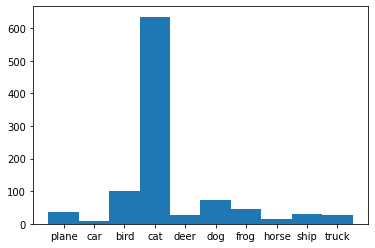

In [69]:
import numpy as np                                                               
import matplotlib.pyplot as plt
top = [('plane',36), ('car',9), ('bird',100), ('cat',635),
           ('deer',27), ('dog',73), ('frog',46), ('horse',16), ('ship',29), ('truck',28)]
# top=[('a',1.875),('c',1.125),('d',0.5)]

# labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
# plt.yticks(ys)

# plt.savefig('netscore.png')